# Capstone Project - Battle of the Neighborhoods
### By Audrey B

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

People who are planning to moving to San Francisco are faced with many options when choosing a neighborhood. Different categories of people have different priorities for example, working married couples without children, working married couples with children, and retired people. Some examples of different priorities are the number of schools, parks, hospitals, the access to public transportation, and the price of rent.

Potential qualities of a neighborhood that people could be interested in are:

-the number of schools in the neighborhood

-the number of parks in the neighborhood

-the number of hospitals in the neighborhood

-the number of restaurants in the neighborhood

-the number of grocery stores in the neighborhood

-the number of bars/clubs in the neighborhood

-the number of retail stores in the neighborhood

-the availability of public transit in the neighborhood

-the crime rate in the neighborhood

-the rent price in the neighborhood

Future residents are able to prioritize particular amenities to help them find the neighborhood that best suits their needs using clustering methods. Using the Foursquare location data, we are able to determine how many parks, schools, restaurants, grocery stores, bars/clubs, and retail stores are in a particular neighborhood. We are able to cross-reference that data with the average rent prices of each neighborhood in order to provide the future residents of San Francisco with the information they need to best choose the neighborhood that suits their needs and wants. 

## Data <a name="data"></a>

In order to obtain the coordinates of each neighborhood, we start by scraping the latitude and logitude values from the https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4 website along with the neighborhood names.

To get the average rent prices of each neighborhood, we use the data from https://www.rentcafe.com/average-rent-market-trends/us/ca/san-francisco/.

Using Foursquare, we find the venues in each neighborhood into the categories we listed above (parks, schools, restaurants, grocery stores, bars/clubs, and retail stores) and save the counts of each category by neighborhood.

Once we have collected all the data on the number of venues in each neighborhood by category, we are able to then form clusters, using heirarchical clustering methods, of similar neighborhoods that we can ultimately use to suggest a group of neighborhoods fitting to a person's criteria.

### Neighborhood Candidates

There are 55 neighborhoods in San Francisco that serve as all possible candidates for a neighborhood to live in.

We started by downloading .kml file of the coordinates of each neighborhood from https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4 and used grep in the shell to extract the relevant data and put it into an Excel sheet that we then exported as a .csv file.

We also scraped the website, https://www.rentcafe.com/average-rent-market-trends/us/ca/san-francisco/ for the average rent of each neighborhood. Then, in Excel, we cross-referenced the two datasets, the neighborhood latitude and longitude and the neighborhood average rent, and we kept neighborhoods that had values for all three components, latitude, longitude, and average rent and exported them as a .csv file that we then uploaded to the notebook.

In [1]:
import pandas as pd
sf_neighborhoods = pd.read_csv('rent_lat_long.csv')
sf_neighborhoods.head()

,Neighborhood,Average Rent,Latitude,Longitude
0,Alamo Square,"$3,456",37.791173,-122.43767
1,Anza Vista,"$3,468",37.725000,-122.44500
2,Barbary Coast,"$3,412",37.726870,-122.38873
3,Bayview‚ Hunters Point,"$3,361",37.718590,-122.43164
4,Bernal Heights,"$3,061",37.756680,-122.50676


Now that we have all the coordinates of each neighborhood, let's map them to see where they are.

In [2]:
import folium
sf_coordinates = [37.77, -122.42]
map_sf = folium.Map(location = sf_coordinates, zoom_start=12)
for lat, lon in zip(sf_neighborhoods['Latitude'], sf_neighborhoods['Longitude']):
    folium.Marker([lat, lon]).add_to(map_sf)
map_sf

### Foursquare

Now that we have seen where the neighborhoods are, we can now use the coordinates in Foursquare to explore the neighborhoods.

Foursquare credentials are defined in the cell below.

In [3]:
CLIENT_ID = '3GE5CW3U2RSRRV5TUA32CJAGG2JGYX1T04RGGXE2B12YR0HE' # your Foursquare ID
CLIENT_SECRET = 'XGJLF2GEZLVOZXM2RSOOUDQX4IKRJMUPJ5WWD3NMP3KGOYD1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100

In [4]:
# Foursquare category IDs corresponding to categories of interest; taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):
categories_dic = {'Parks':'4bf58dd8d48988d163941735', # Category for all parks
                 'Schools':'4f4533804b9074f6e4fb0105', # Category for all elementary schools
                 'Grocery Stores':'4bf58dd8d48988d118951735', # Category for all grocery stores
                 'Retail':'4bf58dd8d48988d103951735', # Category for all clothing stores
                 'Restaurants':'4d4b7105d754a06374d81259', # 'Root' category for all food-related venues
                 'Bars':'4d4b7105d754a06376d81259'} # 'Root' category for all nightlife-related venues

import requests

def getNearbyVenues(names, latitudes, longitudes, catname, catid, radius=500):
    
    venue_counts = pd.DataFrame()
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            catid,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only the count for each category by neighborhood
        count = 0
        for v in results:
            count += 1
        venue_counts = venue_counts.append({'Neighborhood':name, 'Category':catname, 'Count':count}, ignore_index=True)
    
    return(venue_counts)

def getVenueByCategory(names, latitudes, longitudes, category):
    
    category_counts = sf_neighborhoods.copy()
    for catname,catid in category.items():
        nearby_venues = getNearbyVenues(names, latitudes, longitudes, catname, catid)
        
        # merging category counts with sf neighborhoods data
        category_counts = category_counts.merge(nearby_venues, on='Neighborhood')
        category_counts = category_counts.rename(columns={'Count':nearby_venues['Category'][0]})
        category_counts = category_counts.drop(columns=['Category'], axis=1)
        
    return (category_counts)

sf_counts = getVenueByCategory(sf_neighborhoods['Neighborhood'], sf_neighborhoods['Latitude'], sf_neighborhoods['Longitude'], categories_dic)
sf_counts

,Neighborhood,Average Rent,Latitude,Longitude,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars
0,Alamo Square,"$3,456",37.791173,-122.437670,5.0,6.0,4.0,52.0,28.0,8.0
1,Anza Vista,"$3,468",37.725000,-122.445000,6.0,0.0,1.0,0.0,6.0,2.0
2,Barbary Coast,"$3,412",37.726870,-122.388730,2.0,0.0,1.0,1.0,16.0,3.0
3,Bayview‚ Hunters Point,"$3,361",37.718590,-122.431640,1.0,1.0,0.0,0.0,1.0,0.0
4,Bernal Heights,"$3,061",37.756680,-122.506760,4.0,0.0,3.0,2.0,17.0,6.0
5,Civic Center,"$2,944",37.755255,-122.451812,1.0,1.0,0.0,0.0,1.0,0.0
6,Clarendon Heights,"$4,153",37.764850,-122.449750,5.0,1.0,5.0,2.0,13.0,5.0
7,Cole Valley,"$3,809",37.762528,-122.409861,3.0,1.0,2.0,6.0,27.0,14.0
8,Corona Heights,"$4,427",37.798072,-122.444345,4.0,0.0,1.0,12.0,21.0,14.0
9,Cow Hollow,"$3,632",37.712820,-122.439450,0.0,0.0,1.0,4.0,28.0,4.0


In [5]:
# save the data locally so we don't have to keep making calls to the API
sf_counts.to_csv('sf_counts.csv', index=False)

We have gathered the data from Foursquare telling us how many of venues of each category there are in each neighborhood.

This concludes the data gathering phase, we're now ready to use this data for analysis to produce the report on finding an ideal neighborhood based on individual criteria.

## Methodology <a name="methodology"></a>

In this project, we will focus our analysis on determining which neighborhood is ideal for individuals based on what kind of amenities they are interested in having in their neighborhood. In addition, they will also be able to compare the prices of rent in the suggested neighborhoods.

In the previous section, we collected the data on the locations and the average rents of the neighborhoods, which we then used to query the Foursquare API. The Foursquare API gave us information on how many venues were in each category of interest by neighborhood.

In this next section, first, we will normalize the counts for each category. Next, we will cluster neighborhoods, using Ward-heirarchical clustering, into groups with similar characteristics. Then, the user input will be used to select the cluster that best matches their input. Last, we will return the neighborhoods to the user along with the characteristics of each neighborhood and average rent of each neighborhood.

## Analysis <a name="analysis"></a>

Using a radius of 500 in each neighborhood, the results are as follows:

In [6]:
sf_counts.describe()

,Latitude,Longitude,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,37.764277,-122.434443,4.218182,0.945455,3.981818,15.309091,30.836364,12.763636
std,0.028367,0.031086,3.016565,1.208277,5.775077,24.630509,25.529767,14.348782
min,37.711111,-122.506760,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.740811,-122.451864,2.000000,0.000000,0.000000,0.000000,7.500000,2.000000
50%,37.769800,-122.432760,4.000000,1.000000,2.000000,3.000000,28.000000,6.000000
75%,37.786539,-122.411823,6.000000,1.000000,5.000000,21.500000,52.000000,19.000000
max,37.809912,-122.366002,15.000000,6.000000,29.000000,100.000000,92.000000,57.000000


In [7]:
min_max = []
col_names = sf_counts.columns

for i in range(4,10):
    maxes = sf_counts['Neighborhood'].loc[sf_counts.iloc[:,i].idxmax()]
    mins = sf_counts['Neighborhood'].loc[sf_counts.iloc[:,i].idxmin()]
    cat = col_names[i]
    min_max.append([cat, mins, maxes])

min_max

[['Parks', 'Cow Hollow', 'Noe Valley'],
 ['Schools', 'Anza Vista', 'Alamo Square'],
 ['Grocery Stores', 'Bayview‚ Hunters Point', 'Noe Valley'],
 ['Retail', 'Anza Vista', 'Tenderloin'],
 ['Restaurants', 'Presidio', 'Mission District'],
 ['Bars', 'Bayview‚ Hunters Point', 'Telegraph Hill']]

On average, there are 4 parks in each neighborhood, with Noe Valley having the most, and Cow Hollow having the least.

On average, there are 1 schools in each neighborhood, with Alamo Square having the most, and Anza Vista having the least.

On average, there are 4 grocery stores in each neighborhood, with Noe Valley having the most, and Bayview, Hunters Point having the least.

On average, there are 15 retail stores in each neighborhood, with Tenderloin having the most, and Anza Vista having the least.

On average, there are 31 restaurants in each neighborhood, with Mission District having the most, and Presidio neighborhood having the least.

On average, there are 13 bars in each neighborhood, with Telegraph Hill having the most, and Bayview, Hunters Point having the least.

Now we will begin building our heirarchical clustering model.

In [8]:
# create the features dataframe
features = sf_counts.drop(columns=['Neighborhood', 'Latitude', 'Longitude'], axis=1)
features[features.columns[0]] = features[features.columns[0]].replace('[\$,]', '', regex=True).astype(float)
features.head()

,Average Rent,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars
0,3456.0,5.0,6.0,4.0,52.0,28.0,8.0
1,3468.0,6.0,0.0,1.0,0.0,6.0,2.0
2,3412.0,2.0,0.0,1.0,1.0,16.0,3.0
3,3361.0,1.0,1.0,0.0,0.0,1.0,0.0
4,3061.0,4.0,0.0,3.0,2.0,17.0,6.0


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
sf_scaled = pd.DataFrame(min_max_scaler.fit_transform(features), columns=features.columns, index=features.index)
sf_scaled.head()

,Average Rent,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars
0,0.362069,0.333333,1.000000,0.137931,0.52,0.304348,0.140351
1,0.367241,0.400000,0.000000,0.034483,0.00,0.065217,0.035088
2,0.343103,0.133333,0.000000,0.034483,0.01,0.173913,0.052632
3,0.321121,0.066667,0.166667,0.000000,0.00,0.010870,0.000000
4,0.191810,0.266667,0.000000,0.103448,0.02,0.184783,0.105263


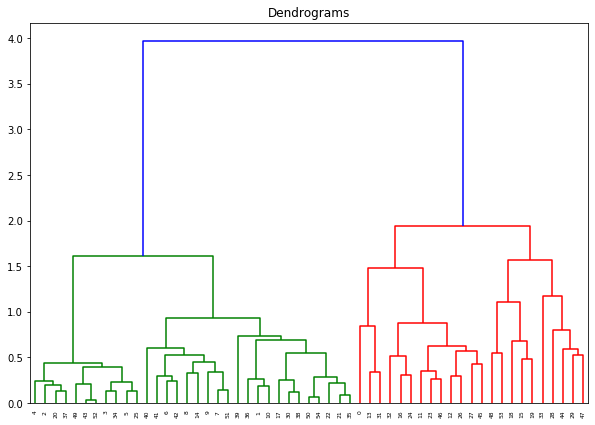

In [11]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(sf_scaled, method='ward'))

In [15]:
# normalize data & generate clusters
from sklearn.cluster import AgglomerativeClustering
CLUSTERS=5
cluster = AgglomerativeClustering(n_clusters=CLUSTERS, affinity='euclidean', linkage='ward') 
cluster_labels = cluster.fit_predict(sf_scaled)
cluster_labels

array([0, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 0, 0, 0, 4, 1, 0, 4, 1, 1, 3, 4,
       4, 0, 0, 3, 0, 0, 2, 2, 4, 0, 0, 2, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3,
       2, 0, 0, 2, 1, 3, 4, 4, 3, 1, 4])

In [16]:
# add cluster labels to neighborhoods
sf_counts['Cluster Label'] = cluster_labels
sf_counts.head()

,Neighborhood,Average Rent,Latitude,Longitude,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars,Cluster Label
0,Alamo Square,"$3,456",37.791173,-122.43767,5.0,6.0,4.0,52.0,28.0,8.0,0
1,Anza Vista,"$3,468",37.725000,-122.44500,6.0,0.0,1.0,0.0,6.0,2.0,4
2,Barbary Coast,"$3,412",37.726870,-122.38873,2.0,0.0,1.0,1.0,16.0,3.0,3
3,Bayview‚ Hunters Point,"$3,361",37.718590,-122.43164,1.0,1.0,0.0,0.0,1.0,0.0,3
4,Bernal Heights,"$3,061",37.756680,-122.50676,4.0,0.0,3.0,2.0,17.0,6.0,3


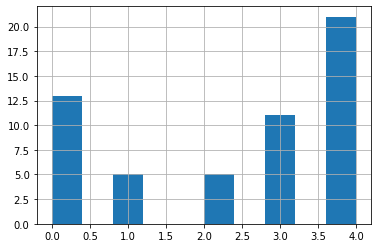

In [17]:
# see the distribution of clusters
sf_counts['Cluster Label'].hist()

In [18]:
cluster_index = sf_counts.groupby('Cluster Label')
cluster_index.groups

{0: Int64Index([0, 11, 12, 13, 16, 23, 24, 26, 27, 31, 32, 45, 46], dtype='int64'),
 1: Int64Index([15, 18, 19, 48, 53], dtype='int64'),
 2: Int64Index([28, 29, 33, 44, 47], dtype='int64'),
 3: Int64Index([2, 3, 4, 5, 20, 25, 34, 37, 43, 49, 52], dtype='int64'),
 4: Int64Index([1, 6, 7, 8, 9, 10, 14, 17, 21, 22, 30, 35, 36, 38, 39, 40, 41, 42,
             50, 51, 54],
            dtype='int64')}

In [19]:
# find the neighborhoods in each cluster
clusters_dic = {}
for j in range(0,CLUSTERS):
    values_list = []
    for i in cluster_index.groups[j]:
        values_list.append(sf_counts['Neighborhood'][i])
    clusters_dic.update({j:values_list})
print(clusters_dic)

{0: ['Alamo Square', 'Diamond Heights', 'Dogpatch', 'Duboce Triangle', 'Financial District', 'Lone Mountain', 'Lower Pacific Heights', 'Merced Manor', 'Midtown Terrace', 'Mount Davidson', 'Nob Hill', 'South of Market', 'Sunset District'], 1: ['Excelsior District', 'Glen Park', 'Haight-Ashbury', 'Tenderloin', 'Westwood Park'], 2: ['Mission Bay', 'Mission District', 'Noe Valley', 'Silver Terrace', 'Telegraph Hill'], 3: ['Barbary Coast', 'Bayview‚ Hunters Point', 'Bernal Heights', 'Civic Center', 'Hayes Valley', 'Marina District', 'North Beach', 'Pacific Heights', 'Russian Hill', 'Treasure Island', 'Western Addition'], 4: ['Anza Vista', 'Clarendon Heights', 'Cole Valley', 'Corona Heights', 'Cow Hollow', 'Crocker-Amazon', 'Eureka Valley', 'Forest Knolls', 'Laurel Heights', 'Little Hollywood', 'Mission Dolores', 'Oceanview', 'Outer Mission', 'Potrero Hill', 'Presidio', 'Presidio Heights', 'Richmond District', 'Rincon Hill', 'Twin Peaks', 'Visitacion Valley', 'Yerba Buena']}


In [20]:
# find the average (unscaled) characteristics of each cluster
cluster_averages = sf_counts.groupby('Cluster Label').agg(np.mean)
cluster_averages

,Latitude,Longitude,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars
Cluster Label,,,,,,,,
0,37.780771,-122.417244,5.384615,1.538462,5.076923,18.692308,47.384615,17.384615
1,37.779529,-122.423008,8.000000,1.200000,5.400000,78.200000,62.400000,28.000000
2,37.778150,-122.416191,6.800000,1.800000,17.400000,30.600000,68.200000,43.200000
3,37.739607,-122.451821,1.363636,0.363636,0.636364,0.545455,7.363636,2.181818
4,37.760055,-122.443055,3.476190,0.619048,1.523810,2.333333,16.476190,4.571429


In [21]:
#find the centers (scaled) of each cluster
sf_scaled['Cluster Label'] = cluster_labels
cluster_centers = sf_scaled.groupby('Cluster Label').agg(np.mean)
cluster_centers

,Average Rent,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars
Cluster Label,,,,,,,
0,0.425000,0.358974,0.256410,0.175066,0.186923,0.515050,0.304993
1,0.436034,0.533333,0.200000,0.186207,0.782000,0.678261,0.491228
2,0.422845,0.453333,0.300000,0.600000,0.306000,0.741304,0.757895
3,0.193926,0.090909,0.060606,0.021944,0.005455,0.080040,0.038278
4,0.575554,0.231746,0.103175,0.052545,0.023333,0.179089,0.080201


In [22]:
def normalize_ratings(ratings_list):
    normal_ratings = []
    for val in ratings_list:
        normal_ratings.append(val/10.0)
    return(normal_ratings)

def getUserInput(categories):
    user_ratings = []
    for key in categories_dic.keys():
        rating = float(input('Rating of ' + key + ' (a number from 0-10): '))
        user_ratings.append(rating)
    user_ratings = normalize_ratings(user_ratings)
    return(user_ratings)
        
norm_ratings = getUserInput(categories_dic)
norm_ratings

Rating of Parks (a number from 0-10): 9
Rating of Schools (a number from 0-10): 1
Rating of Grocery Stores (a number from 0-10): 8
Rating of Retail (a number from 0-10): 6
Rating of Restaurants (a number from 0-10): 4
Rating of Bars (a number from 0-10): 2


[0.9, 0.1, 0.8, 0.6, 0.4, 0.2]

In [23]:
# choose the best cluster based on user input
def computeDistances(norm):
    dist_to_center = []
    for j in range(0,CLUSTERS):
        center = cluster_centers.iloc[j]
        ss = 0.0
        for i in range(1,7):
            ss += (center[i] - norm[i-1])**2
        dist_to_center.append(ss)
    return dist_to_center

computeDistances(norm_ratings)

[0.902607694106726,
 0.7165533186744115,
 0.7936823063522235,
 1.7435649499690433,
 1.4009602103951313]

In [24]:
# outputs the recommended neighborhoods along with their average rent
def determineRecommendedNeighborhood(norm_ratings):
    dist_to_center = computeDistances(norm_ratings)
    index = dist_to_center.index(min(dist_to_center))
    recommended_neighborhoods = sf_counts.iloc[cluster_index.groups[index],[0,1,4,5,6,7,8,9]]
    return recommended_neighborhoods

determineRecommendedNeighborhood(norm_ratings)

,Neighborhood,Average Rent,Parks,Schools,Grocery Stores,Retail,Restaurants,Bars
15,Excelsior District,"$3,907",11.0,2.0,3.0,47.0,44.0,14.0
18,Glen Park,"$3,571",7.0,0.0,3.0,81.0,42.0,15.0
19,Haight-Ashbury,"$3,809",9.0,3.0,3.0,63.0,77.0,24.0
48,Tenderloin,"$2,944",5.0,0.0,12.0,100.0,78.0,40.0
53,Westwood Park,"$3,907",8.0,1.0,6.0,100.0,71.0,47.0


Based on this example user input, this is the data for the recommended neighborhoods.

This concludes our section on analysis. We have created 5 clusters of neighborhoods and have shown an example of neighborhood suggestions based on user input.

## Results and Discussion <a name="results"></a>

Our analysis shows that the neighborhoods of San Francisco can be clustered based on the types of venues within each neighborhood. Once we created the clusters, we were then able to suggests neighborhoods within San Francisco to future residents based on their ideal amenities.

In [ ]:
# try the algorithm with your own inputs
norm_ratings = getUserInput(categories_dic)
determineRecommendedNeighborhood(norm_ratings)

# Conclusion <a name="conclusion"></a>

The purpose of this project was to provide future residents of San Francisco with a suggestion of what neighborhood they should live in based on how they rate certain aspects of a neighborhood. By counting how many of a certain type of venue were in each neighborhood using Foursquare, we were able to cluster the neighborhoods of San Francisco based on how similar differing neighborhoods are. We ended up with 5 unique clusters which we could then best fit to individuals' desires and also provided them with the average rent for each neighborhood so they could make the best informed decision.

The final decision comes down to the individual, their lifestyle, their budget, the availability of rentals, the rental property's condition and its amenities. Obviously, there are many factors that we did not take into account, but we try our best to give our users the best neighborhood suggestion based on their inputs and the data we've collected so that they are able to make a well-informed decision when it comes to choosing where to live in the city of San Francisco.